In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

C:\Users\aslak\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_adding_problem_data(num_samples, t_steps=6):
    X_num = np.random.uniform(low=0, high=1, size=(num_samples, t_steps, 1))
    X_mask = np.zeros((num_samples, t_steps, 1))
    Y = np.ones((num_samples, 1))
    for i in range(num_samples):
        # Default uniform distribution on position sampling
        positions = np.random.choice(t_steps, size=2, replace=False)
        X_mask[i, positions] = 1
        Y[i, 0] = np.sum(X_num[i, positions])
    X = np.append(X_num, X_mask, axis=2)
    return X, Y

In [10]:
class AddingProblemRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size = 128, output_size=1, lr=0.001, t_steps=100, batch_size=100):
        super(AddingProblemRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.t_steps = t_steps
        self.batch_size = batch_size
        
        
        self.rnn = nn.RNN(input_size, hidden_size)
        torch.nn.init.eye_(self.rnn.weight_hh_l0)
        torch.nn.init.constant_(self.rnn.bias_hh_l0, 0)
        torch.nn.init.constant_(self.rnn.bias_ih_l0, 0)
        
        self.fc = nn.Linear(hidden_size, output_size)
        self.criterion = nn.MSELoss()
        self.opt = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x, h):
        x = x.view(self.t_steps, self.batch_size, self.input_size)
        out, hidden = self.rnn(x, h)
        out = self.fc(out)
        return out, hidden

    def train_step(self, inputs, labels):
        h = torch.zeros(1, self.batch_size, self.hidden_size)
        self.opt.zero_grad()
        outputs, _ = self.forward(inputs, h)
        loss = self.criterion(outputs[-1], labels)
        loss.backward()
        self.opt.step()
        return loss.item()

    def predict(self, inputs):
        h = torch.zeros(1, self.batch_size, self.hidden_size)
        outputs, _ = self.forward(inputs, h)
        return outputs.squeeze(1).detach().numpy()

Epoch 0, train loss: 0.54705, test loss: 10.54738
Epoch 100, train loss: 0.17376, test loss: 1.52491
Epoch 200, train loss: 0.16316, test loss: 1.28386
Epoch 300, train loss: 0.16241, test loss: 1.25636
Epoch 400, train loss: 0.16122, test loss: 1.24109
Epoch 500, train loss: 0.20386, test loss: 1.32850
Epoch 600, train loss: 0.16808, test loss: 1.84604
Epoch 700, train loss: 0.16514, test loss: 1.77363
Epoch 800, train loss: 0.16307, test loss: 1.92001
Epoch 900, train loss: 0.16140, test loss: 2.08454


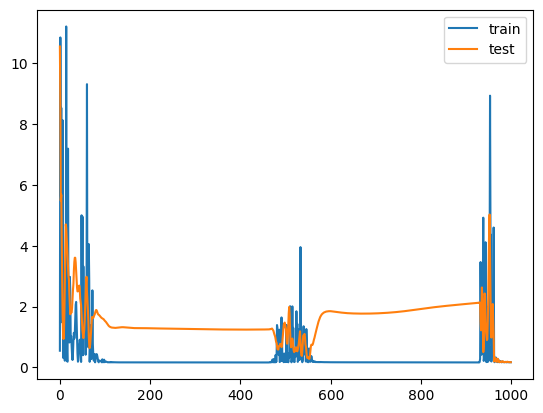

In [22]:
import matplotlib.pyplot as plt

# Set the hyperparameters
t_steps = 100
batch_size = 256
num_epochs = 1000
lr = 0.01
hidden_size = 128

# Generate the training and testing data
X_train, y_train = generate_adding_problem_data(num_samples = batch_size, t_steps = t_steps)
X_test, y_test = generate_adding_problem_data(num_samples = batch_size, t_steps = t_steps)

# Initialize the model
model = AddingProblemRNN(input_size=2, hidden_size=hidden_size, output_size=1, lr=lr, t_steps=t_steps, batch_size=batch_size)

# Train the model
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # Train on one batch of data
    train_loss = model.train_step(torch.tensor(X_train).float(), torch.tensor(y_train).float())
    train_losses.append(train_loss)

    # Test on one batch of data
    test_loss = model.criterion(torch.tensor(model.predict(torch.tensor(X_test).float())), torch.tensor(y_test).float())
    test_losses.append(test_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, train loss: {train_loss:.5f}, test loss: {test_loss.item():.5f}")

# Plot the training and testing losses
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.legend()
plt.show()


In [40]:

X_test, y_test = generate_adding_problem_data(num_samples = batch_size, t_steps = t_steps)
def measure_accuracy(model, X, Y):
    # Get predicted outputs from the model
    Y_pred = model.predict(torch.tensor(X).float())

    # Round predicted values to the nearest integer
    Y_pred = np.round(Y_pred)

    # Compute the accuracy as the fraction of correct predictions
    accuracy = np.mean((Y_pred - Y) < 0.05)

    return accuracy

print(measure_accuracy(model, X_test, y_test))

0.5537109375


In [20]:
accuracies = []
for t in range(2, 80, 2):
    X_train, y_train = generate_adding_problem_data(num_samples = batch_size, t_steps = t)
    X_test, y_test = generate_adding_problem_data(num_samples = batch_size, t_steps = t)
    model = AddingProblemRNN(input_size=2, hidden_size=hidden_size, output_size=1, lr=lr, t_steps=t, batch_size=batch_size)
    # Train the model
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        # Train on one batch of data
        train_loss = model.train_step(torch.tensor(X_train).float(), torch.tensor(y_train).float())
        train_losses.append(train_loss)

        # Test on one batch of data
        test_loss = model.criterion(torch.tensor(model.predict(torch.tensor(X_test).float())), torch.tensor(y_test).float())
        test_losses.append(test_loss.item())

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, train loss: {train_loss:.5f}, test loss: {test_loss.item():.5f}")
        
    accuracies.append(measure_accuracy(model, X_test, y_test))

plt.plot(range(5, 80,2), accuracies)

Epoch 0, train loss: 1.03651, test loss: 0.38938
Epoch 100, train loss: 0.17390, test loss: 0.30073
Epoch 200, train loss: 0.17369, test loss: 0.29312
Epoch 300, train loss: 0.17367, test loss: 0.29277
Epoch 400, train loss: 0.17365, test loss: 0.29218
Epoch 500, train loss: 0.17363, test loss: 0.29078
Epoch 600, train loss: 0.17174, test loss: 0.28429
Epoch 700, train loss: 0.16651, test loss: 0.29425
Epoch 800, train loss: 0.16648, test loss: 0.30010
Epoch 900, train loss: 0.16643, test loss: 0.30739
Epoch 0, train loss: 0.89323, test loss: 0.59216
Epoch 100, train loss: 0.15861, test loss: 0.52269
Epoch 200, train loss: 0.15635, test loss: 0.56242
Epoch 300, train loss: 0.15477, test loss: 0.61560
Epoch 400, train loss: 0.14549, test loss: 0.59643
Epoch 500, train loss: 0.14371, test loss: 0.68508
Epoch 600, train loss: 0.13386, test loss: 0.75028


KeyboardInterrupt: 

In [ ]:
plt.plot(range(2, 80,2), accuracies)